In [1]:
import tidy3d as td
import tidy3d.web as web
from tidy3d import material_library, Medium, Structure

import autograd
from autograd.tracer import getval
import autograd.numpy as anp
from typing import List, Tuple

import matplotlib.pylab as plt
import numpy as np
import os
import optax

## Create Simulation Structures

### Define basic simulation parameters

Most custom parameters are defined in the following block. However, the `param_to_design_info` needs to be carefully reviewed if the structure has changes in the layer numbers and dielectric/metal combinations as it is tightly bound to a specific structure.

In [2]:
Ni = material_library["Ni"]["RakicLorentzDrude1998"]  # Valid for 0.25 - 6.2 um
SiO2 = Medium(permittivity=2.08, name="SiO2")

bandwidth = 0.15  # microns
wvl_range = [3.30, 5.20]  # microns
freq_range = [td.C_0 / wvl_range[1], td.C_0 / wvl_range[0]]
wvl_points = 51  # Must be an odd number
wvls = anp.linspace(wvl_range[0], wvl_range[1], wvl_points)
freqs = np.flip(td.C_0 / wvls)

wvl0 = np.mean(wvl_range)
freq0 = td.C_0 / wvl0

print(f"Center frequency:\t{freq0: .2e} Hz")
print(f"Center wavelength:\t{wvl0} um")
print(f"Target bandwidth:\t{bandwidth} um")
print(f"Frequency range:\t[{freq_range[0]: .2e}, {freq_range[1]: .2e}] Hz")
print(f"Wavelength range:\t{wvl_range} um")

fwidth = freqs.max() - freqs.min()
run_time = 300 / fwidth
shutoff = 1e-4

print(f"\nSource frequency width:\t{fwidth: .2e} Hz")
print(f"Run time:\t\t{run_time: .2e} s")
print(f"Shutoff:\t\t{shutoff: .2e} W/m^2")

# only three freqs for now for async run

# monitor_freqs = [freqs[0], freqs[freqs.size // 2], freqs[-1]]
# monitor_wvls = [3.95, 4.10, 4.20, 4.25, 4.30, 4.35, 4.50, 4.80]
# monitor_wvls = [3.794, 3.946, 4.098, 4.193, 4.307]
# monitor_wvls = [4.25, 4.30]
# monitor_wvls = np.array([3.3, 3.338, 3.395, 3.604, 3.794, 4.098, 4.307, 4.402, 4.497, 4.592, 4.706, 4.801, 4.896, 4.953])
monitor_wvls = np.array([3.3, 3.395, 3.604, 3.794, 3.90, 3.95, 4.098, 4.15, 4.25, 4.32, 4.402, 4.497, 4.592, 4.706, 4.801, 4.953])
monitor_freqs = np.flip(td.constants.C_0 / monitor_wvls)
#monitor_wvls = np.array([3.642, 3.794, 3.946, 4.098, 4.193, 4.307, 4.497, 4.801])
#monitor_freqs = np.flip(td.constants.C_0 / monitor_wvls)
wvl_points = len(monitor_wvls)

print(f"\nMonitor frequency range: [{monitor_freqs[0]: .2e}, {monitor_freqs[-1]: .2e}] Hz")

buffer_size = 0.1  # distance between the source and the monitor
distance = wvl0  # distance between the source/monitor/structure and the PML

# Define the structure constraints
# Default substrate values
sub_metal_thickness = 0.2
sub_dielectric_thickness = 0.25
num_of_sub_layers = 2
# Substrate constraints
sub_metal_min_thickness = 0.1
sub_metal_max_thickness = 0.3
sub_dielectric_min_thickness = 0.15
sub_dielectric_max_thickness = 0.35
sub_thickness_constraints_min = [sub_metal_min_thickness, sub_dielectric_min_thickness]
sub_thickness_constraints_max = [sub_metal_max_thickness, sub_dielectric_max_thickness]

# Default cuboid values
cuboid_metal_thickneness = 0.025
cuboid_dielectric_thickness = 0.1
num_of_cuboid_layers = 2 * 5  # 5 bilayers
# Cuboid constraints
cuboid_min_length = 1.0
cuboid_max_length = 3.4
cuboid_min_width = 1.0
cuboid_max_width = 3.4
cuboid_metal_min_thickness = 0.015
cuboid_metal_max_thickness = 0.035
cuboid_dielectric_min_thickness = 0.05
cuboid_dielectric_max_thickness = 0.2
cuboid_thickness_constraints_min = [
    cuboid_metal_min_thickness,
    cuboid_dielectric_min_thickness,
    cuboid_metal_min_thickness,
    cuboid_dielectric_min_thickness,
    cuboid_metal_min_thickness,
    cuboid_dielectric_min_thickness,
    cuboid_metal_min_thickness,
    cuboid_dielectric_min_thickness,
    cuboid_metal_min_thickness,
    cuboid_dielectric_min_thickness,
]
cuboid_thickness_constraints_max = [
    cuboid_metal_max_thickness,
    cuboid_dielectric_max_thickness,
    cuboid_metal_max_thickness,
    cuboid_dielectric_max_thickness,
    cuboid_metal_max_thickness,
    cuboid_dielectric_max_thickness,
    cuboid_metal_max_thickness,
    cuboid_dielectric_max_thickness,
    cuboid_metal_max_thickness,
    cuboid_dielectric_max_thickness,
]

sub_materials = [Ni, SiO2]
cuboid_materials = [Ni, SiO2, Ni, SiO2, Ni, SiO2, Ni, SiO2, Ni, SiO2]

# Simulation domain
Lx = 3.5
Ly = 3.5
Lz = (
    2 * wvl0
    + buffer_size
    + distance
    + sub_metal_max_thickness
    + sub_dielectric_max_thickness
    + 5 * (cuboid_metal_max_thickness + cuboid_dielectric_max_thickness)
)
min_steps_per_wvl = 10  # outside of structure
# fine discretization in propagation direction
# make sure to double-check discretization in xy
override_dl = (0.1, 0.1, 0.005)

Center frequency:	 7.05e+13 Hz
Center wavelength:	4.25 um
Target bandwidth:	0.15 um
Frequency range:	[ 5.77e+13,  9.08e+13] Hz
Wavelength range:	[3.3, 5.2] um

Source frequency width:	 3.32e+13 Hz
Run time:		 9.04e-12 s
Shutoff:		 1.00e-04 W/m^2

Monitor frequency range: [ 6.05e+13,  9.08e+13] Hz


### Define source and monitor objects

In [3]:
SOURCE_PLANEWV_NAME = "source_planewave"
FLUX_MONITOR_NAME = "monitor_flux"

source_planewave = td.PlaneWave(
    center=(0, 0, Lz / 2 - wvl0 - buffer_size),
    source_time=td.GaussianPulse(freq0=freq0, fwidth=fwidth),
    size=(td.inf, td.inf, 0),
    direction="-",
    pol_angle=0,
    name=SOURCE_PLANEWV_NAME,
)

### Function to create the structure

Parameter frame structure: 

| substrate thicknesses from bottom up | cuboid thicknesses from bottom up | cuboid length | cuboid width |
| --- | --- | --- | --- |

Every data frame is a NumPy array, which then form a Tuple.

In [4]:
def make_dynamic_structures(design_info: Tuple) -> List[Structure]:
    if design_info is None:
        return []

    sub_thicknesses, cuboid_thicknesses, cuboid_length, cuboid_width = design_info
    sub_thicknesses = anp.clip(sub_thicknesses, sub_thickness_constraints_min, sub_thickness_constraints_max)
    cuboid_thicknesses = anp.clip(cuboid_thicknesses, cuboid_thickness_constraints_min, cuboid_thickness_constraints_max)
    cuboid_length = anp.clip(cuboid_length, cuboid_min_length, cuboid_max_length)
    cuboid_width = anp.clip(cuboid_width, cuboid_min_width, cuboid_max_width)

    # Substrate
    substrate = []
    z_center = -Lz / 2 + distance
    for i in range(num_of_sub_layers):
        z_center = z_center + sub_thicknesses[i] / 2 + (sub_thicknesses[i - 1] / 2 if i > 0 else 0)

        substrate.append(
            td.Structure(
                geometry=td.Box(
                    center=(0, 0, z_center),
                    size=(td.inf, td.inf, sub_thicknesses[i]),
                ),
                medium=sub_materials[i],
            )
        )

    z_center = z_center + sub_thicknesses[-1] / 2

    # Cuboid
    cuboid = []
    for i in range(num_of_cuboid_layers):
        z_center = (
            z_center + cuboid_thicknesses[i] / 2 + (cuboid_thicknesses[i - 1] / 2 if i > 0 else 0)
        )

        cuboid.append(
            td.Structure(
                geometry=td.Box(
                    center=(0, 0, z_center),
                    size=(cuboid_length[0], cuboid_width[0], cuboid_thicknesses[i]),
                ),
                medium=cuboid_materials[i],
            )
        )

    return substrate + cuboid

### Function to create the simulation object

In [5]:
def make_sim(design_info: Tuple) -> td.Simulation:
    boundary_spec = td.BoundarySpec(
        x=td.Boundary(minus=td.Periodic(), plus=td.Periodic()),
        y=td.Boundary(minus=td.Periodic(), plus=td.Periodic()),
        z=td.Boundary(minus=td.PML(), plus=td.PML()),
    )

    dynamic_structures = make_dynamic_structures(design_info)

    # make mesh override, zmin and zmax are the bounds of the structure rounded down/up to the nearest 0.1
    zmin = np.floor(getval(dynamic_structures[0].geometry.bounds[0][2]) * 10) / 10
    zmax = np.ceil(getval(dynamic_structures[-1].geometry.bounds[1][2]) * 10) / 10
    override = td.MeshOverrideStructure(
        geometry=td.Box.from_bounds((-1e3, -1e3, zmin), (1e3, 1e3, zmax)),
        dl=override_dl,
        enforce=True,
    )

    grid_spec = td.GridSpec.auto(
        wavelength=min(wvl_range),  # always mesh for smallest wavelength
        min_steps_per_wvl=min_steps_per_wvl,
        override_structures=[override],
    )

    sim = td.Simulation(
        center=(0, 0, 0),
        size=(Lx, Ly, Lz),
        run_time=run_time,
        boundary_spec=boundary_spec,
        grid_spec=grid_spec,
        structures=dynamic_structures,
        sources=[source_planewave],
        monitors=[],  # will be added in objective function
        shutoff=shutoff,
        symmetry=(-1, 1, 0),
    )

    return sim

### Check point

In [6]:
def get_spectrum(time: np.array, data: np.array) -> np.array:
    fs = 1 / (time[1] - time[0])
    n = len(data)

    signal_fft = np.fft.fft(data)
    freqs = np.fft.fftfreq(n, 1 / fs)
    spectrum = np.abs(signal_fft)

    # Filter out small values
    threshold = np.max(spectrum) * 1e-3  # 0.1% of the maximum value
    spectrum[spectrum < threshold] = 0

    return freqs, spectrum

Values of random_design_info: (array([0.18719898, 0.10518525]), array([0.02599325, 0.02370645, 0.02340736, 0.0216067 , 0.01909297,
       0.02738542, 0.02099309, 0.02033655, 0.02742268, 0.02558284]), array([1.32299187]), array([2.23258749]))


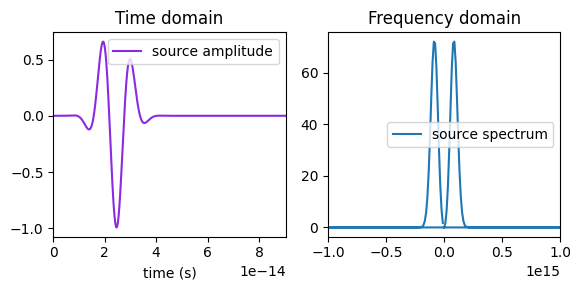

20:03:31 BST Created task 'week08_design_credit_estimation' with task_id        
             'fdve-510a5a6e-1b99-49b0-a6c4-e2d7f6ddfbd0' and task_type 'FDTD'.

             View task using web UI at                                          
             ]8;id=556820;https://tidy3d.simulation.cloud/workbench?taskId=fdve-510a5a6e-1b99-49b0-a6c4-e2d7f6ddfbd0\'https://tidy3d.simulation.cloud/workbench?]8;;\]8;id=689164;https://tidy3d.simulation.cloud/workbench?taskId=fdve-510a5a6e-1b99-49b0-a6c4-e2d7f6ddfbd0\taskId]8;;\]8;id=556820;https://tidy3d.simulation.cloud/workbench?taskId=fdve-510a5a6e-1b99-49b0-a6c4-e2d7f6ddfbd0\=]8;;\]8;id=943096;https://tidy3d.simulation.cloud/workbench?taskId=fdve-510a5a6e-1b99-49b0-a6c4-e2d7f6ddfbd0\fdve]8;;\]8;id=556820;https://tidy3d.simulation.cloud/workbench?taskId=fdve-510a5a6e-1b99-49b0-a6c4-e2d7f6ddfbd0\-510a5a6e-1b9]8;;\
             ]8;id=556820;https://tidy3d.simulation.cloud/workbench?taskId=fdve-510a5a6e-1b99-49b0-a6c4-e2d7f6ddfbd0\9-49b0-a6c4-e2d7f6ddfbd0']8;;\.

Output()

20:03:33 BST Maximum FlexCredit cost: 0.038. Minimum cost depends on task       
             execution details. Use 'web.real_cost(task_id)' to get the billed  
             FlexCredit cost after a simulation run.

Estimated cost: 0.03767501839801318


In [7]:
anp.random.seed(2)

random_sub_thicknesses = anp.random.uniform(
    sub_metal_min_thickness, sub_metal_max_thickness, num_of_sub_layers
)
random_cuboid_thicknesses = anp.random.uniform(
    cuboid_metal_min_thickness, cuboid_metal_max_thickness, num_of_cuboid_layers
)
random_cuboid_length = anp.random.uniform(cuboid_min_length, cuboid_max_length, 1)
random_cuboid_width = anp.random.uniform(cuboid_min_width, cuboid_max_width, 1)

random_design_info = (
    random_sub_thicknesses,
    random_cuboid_thicknesses,
    random_cuboid_length,
    random_cuboid_width,
)

print(f"Values of random_design_info: {random_design_info}")

random_sim = make_sim(random_design_info)

# Plot the source signal in time and frequency domain
times = np.arange(0, random_sim.run_time, random_sim.dt)
amplitudes = np.real(random_sim.sources[0].source_time.amp_time(times))

(fig, (ax_time, ax_freq)) = plt.subplots(1, 2, tight_layout=True, figsize=(6, 3))
ax_time = random_sim.sources[0].source_time.plot(
    times=np.linspace(0, random_sim.run_time / 100, 1001), ax=ax_time
)
ax_time.set_title("Time domain")
ax_time.set_xlim(0, random_sim.run_time / 100)
ax_time.legend(["source amplitude"])

line = ax_time.lines[0]
x_data = line.get_xdata()
y_data = line.get_ydata()

freqs, spectrum = get_spectrum(x_data, y_data)
ax_freq.plot(freqs, spectrum)
ax_freq.set_title("Frequency domain")
ax_freq.set_xlim(-1e15, 1e15)
ax_freq.legend(["source spectrum", "measurement"])

plt.show()

# 3D plot of the random design
random_sim.plot_3d()
plt.show()

# Cost estimation for each simulation
job_random_sim = td.web.Job(
    simulation=random_sim, task_name="week08_design_credit_estimation", verbose=True
)
estimated_cost = td.web.estimate_cost(job_random_sim.task_id)
print(f"Estimated cost: {estimated_cost}")

## Objective Function

### Define the target

Peak value: 0.85, mu: 4.25, sigma: 0.07
wvl_min: 4.10, wvl_max: 4.40


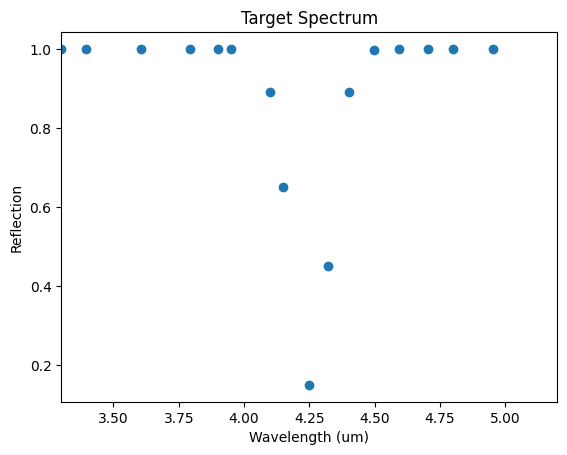

In [8]:
def target_square() -> anp.array:
    wvl_min = wvl0 - bandwidth / 2.0
    wvl_max = wvl0 + bandwidth / 2.0
    print(f"wvl_min: {wvl_min: .2f}, wvl_max: {wvl_max: .2f}")
    return (wvls >= wvl_min) & (wvls <= wvl_max)

def target_gaussian(peak_value: float=0.85, mu: float=wvl0, sigma: float=bandwidth/2.0) -> anp.array:
    target = peak_value * anp.exp(-((monitor_wvls - mu) ** 2) / (2 * sigma ** 2))
    target = 1 - target
    print(f"Peak value: {peak_value:.2f}, mu: {mu:.2f}, sigma: {sigma:.2f}")
    print(f"wvl_min: {mu - 2*sigma:.2f}, wvl_max: {mu + 2*sigma:.2f}")
    
    """
    print(f"Standard Gaussian target: {target}")
    target = anp.array([0.7638304, 0.7572399, 0.74600166, 0.68200403, 0.5219077, 0.14393269, 
        0.53943497, 0.63083637, 0.6791738, 0.69549215, 0.694743,   0.6896028,
        0.68534374, 0.6742493 ])
    """
    return target

plt.scatter(monitor_wvls, target_gaussian())
# plt.scatter(monitor_wvls, target)
plt.xlim(wvl_range[0], wvl_range[1])
plt.xlabel("Wavelength (um)")
plt.ylabel("Reflection")
plt.title("Target Spectrum")
plt.show()

In [9]:
def evaluate_flux_error_MAE(flux: anp.array) -> float:
    target = target_gaussian()
    error = anp.sum(anp.abs(flux - target)) / wvl_points
    return error

def evaluate_flux_error_MSE(flux: anp.array) -> float:
    diff2 = anp.abs(flux - target_gaussian()) ** 2
    error = anp.sum(diff2) / wvl_points
    return error

def evaluate_flux_error_weighted_MAE(flux: anp.array) -> float:
    target = target_gaussian()
    weights = 1 / (target + 1)
    error = anp.sum(weights * anp.abs(flux - target)) / wvl_points
    return error

### Define the objective function

In [10]:
sim_data_history = []
fluxes_history = []

def generate_unique_task(base_path) -> Tuple[str, str]:
    i = 0
    while True:
        new_path = f"data/{base_path}_{i}.hdf5"
        new_name = f"task_{base_path}_{i}"
        if not os.path.exists(new_path):
            return new_name, new_path
        i += 1

def objective_fn(params) -> float:
    sim = make_sim(params)

    sims = {}
    for idx, freq in enumerate(monitor_freqs):
        # we run a separate simulation for each freq
        monitor_flux = td.FieldMonitor(
            center=(0, 0, Lz / 2 - wvl0),
            size=(td.inf, td.inf, 0),
            freqs=[freq],
            name=FLUX_MONITOR_NAME,
        )
        sims[f"flux_{idx}"] = sim.updated_copy(monitors=[monitor_flux])

    print(f"\tUploading batch simulation data...")

    batch_data = web.run_async(sims, verbose=False, path_dir="data")
    
    print(f"\tFinished batch simulation.")
    
    fluxes = [abs(batch_data[k][FLUX_MONITOR_NAME].flux.values.item()) for k in sims]
    error = evaluate_flux_error_weighted_MAE(fluxes)

    sim_data_history.append(batch_data)
    fluxes_history.append(fluxes)

    print(f"\tFinished objective function evaluation.")
    
    return error

## Optimization

### Calculate the initial state

In [11]:
scaling_factor = 0.75

PARAMS0 = (
    anp.array([
        (vmax - vmin) * scaling_factor + vmin
        for vmin, vmax in zip(sub_thickness_constraints_min, sub_thickness_constraints_max)
    ]),
    anp.array([
        (vmax - vmin) * scaling_factor + vmin
        for vmin, vmax in zip(cuboid_thickness_constraints_min, cuboid_thickness_constraints_max)
    ]),
    anp.array([(cuboid_max_length - cuboid_min_length) * scaling_factor + cuboid_min_length]),
    anp.array([(cuboid_max_width - cuboid_min_width) * scaling_factor + cuboid_min_width],),
)

sim_initial = make_sim(PARAMS0)
sim_initial.plot_3d()
plt.show()

In [12]:
# Define the gradient function
val_and_grad_fn = autograd.value_and_grad(objective_fn)

In [13]:
%%script echo skip

val_initial, grad_initial = val_and_grad_fn(PARAMS0)
print(f"Initial design\tFlux error: {val_initial}\tGradient: {grad_initial}")

skip


### Visualize the initial state

In [14]:
# %%script echo skip

def plot_flux(itr: int):
    flux = [flux._value for flux in fluxes_history[-1]]
    plt.figure(figsize=(4, 2))
    plt.plot(monitor_wvls, flux)
    plt.xlabel("Wavelength (um)")
    plt.ylabel("Flux")
    plt.title(f"Flux at iteration {itr}")
    plt.show()

In [15]:
%%script echo skip

plot_flux(0)

skip


To avoid the compatability issues between autograd and optax (which is a native support of Jax), there are some measures taken before and after applying the optimizer updates: 

* params_i is concatenated from a Tuple into a 1D np array
* apply updates
* the updated params_i is then converted to a np array and then restored to the origial shape

The code below utilizes Adam optimizer with optax.

Future exception was never retrieved
future: <Future finished exception=BrokenPipeError(32, 'Broken pipe')>
Traceback (most recent call last):
  File "/Library/Developer/CommandLineTools/Library/Frameworks/Python3.framework/Versions/3.9/lib/python3.9/asyncio/unix_events.py", line 665, in write
    n = os.write(self._fileno, data)
BrokenPipeError: [Errno 32] Broken pipe


Iteration 1
	Uploading batch simulation data...
	Finished batch simulation.
Peak value: 0.85, mu: 4.25, sigma: 0.07
wvl_min: 4.10, wvl_max: 4.40
	Finished objective function evaluation.
	error value: 0.2086161287477007


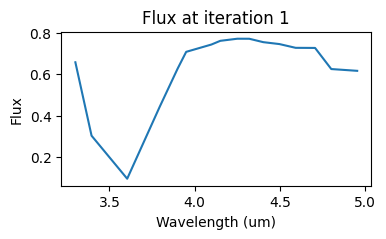

Iteration 2
	Uploading batch simulation data...


KeyboardInterrupt: 

In [16]:
number_of_iterations = 10
step_size = 0.05
optimizer = optax.adam(learning_rate=step_size)
params_i = PARAMS0
shape = [p.size for p in params_i]
sim_i = make_sim(params_i) # Note that sim_i is a List of Simulation objects

optimizer_state = optimizer.init(np.concatenate(params_i))

params_history = [params_i]
error_history = []
grad_history = []
grad_norm_history = []

for i in range(number_of_iterations):
    print(f"Iteration {i + 1}")

    # Compute the value (error) and gradient of the objective function
    val_i, grad_i = val_and_grad_fn(params_i)
    # grad_norm_i = np.linalg.norm(grad_i)

    print(f"\terror value: {val_i}")

    # Visualize the iteration results
    plot_flux(i + 1)

    # Adjusting the step size as the optimization goes on
    step_size = val_i / 10.0
    optimizer = optax.adam(learning_rate=step_size)
    optimizer_state = optimizer.init(np.concatenate(params_i))

    params_i_concatenated = np.concatenate(params_i)
    grad_i_concatenated = np.concatenate(grad_i)

    # Update the parameters: error (loss) as small as possible
    updates, optimizer_state = optimizer.update(grad_i_concatenated, optimizer_state, params_i_concatenated)
    params_i_concatenated = optax.apply_updates(params_i_concatenated, updates) # params_i is now Jax-traced

    # Restore the original shape of the parameters
    params_i = np.array(params_i_concatenated)
    params_i = np.split(params_i, np.cumsum(shape[:-1]))

    # Save the optimization history
    params_history.append(params_i)
    error_history.append(val_i)
    grad_history.append(grad_i)
    # grad_norm_history.append(grad_norm_i)
    # Simulation data history is stored in sim_data_history in objective_fn

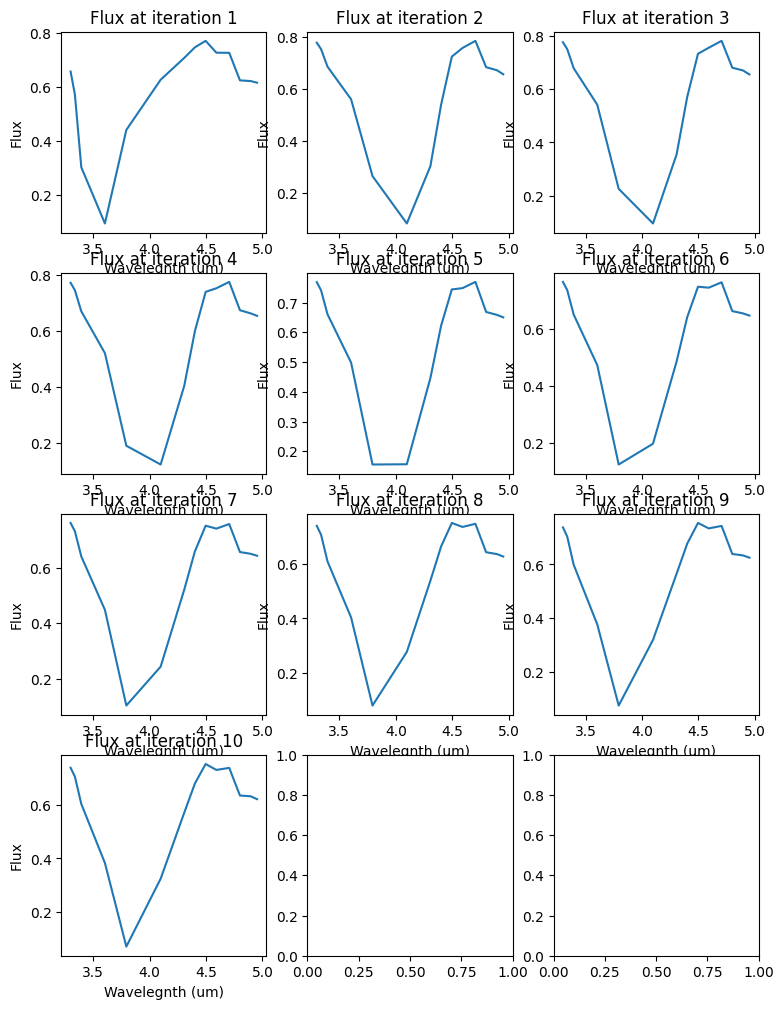

In [ ]:
# Flux history

fig, axes = plt.subplots(4, 3, figsize = (9, 12))
axes = axes.flatten()
for i, flux in enumerate(fluxes_history):
    flux = [flux._value for flux in fluxes_history[i]]
    ax = axes[i]
    ax.plot(monitor_wvls, flux)
    ax.set_title(f'Flux at iteration {i+1}')
    ax.set_xlabel('Wavelegnth (um)')
    ax.set_ylabel('Flux')
# fig.delaxes(axes[-1]) # Delete the last subplot if number_of_iterations == 5
#plt.tight_layout()
plt.savefig("flux_history.png")
plt.show()

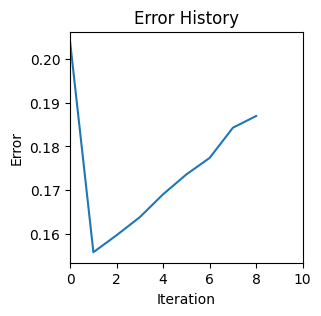

In [ ]:
# Error history
plt.figure(figsize=(3, 3))
plt.plot(error_history)
plt.xlabel("Iteration")
plt.ylabel("Error")
plt.xlim((0, 10))
plt.title("Error History")
plt.show()

In [ ]:
# Retrieve geometric parameters at the 8th iteration
itr = 9
wvl_points_for_checking = 101
wvls_for_checking = np.linspace(wvl_range[0], wvl_range[1], wvl_points_for_checking)
freqs_for_checking = np.flip(td.constants.C_0 / wvls_for_checking)

FLUX_MONITOR_FOR_CHECKING_NAME = 'flux_monitor_for_checking'

monitor_flux_for_checking = td.FluxMonitor(
    center=(0, 0, Lz / 2 - wvl0),
    size=(td.inf, td.inf, 0),
    freqs=freqs_for_checking,
    name=FLUX_MONITOR_FOR_CHECKING_NAME,
)

sim_for_checking = make_sim(params_history[itr-1])
sim_for_checking = sim_for_checking.updated_copy(monitors=[monitor_flux_for_checking])
sim_for_checking.plot_3d()

In [ ]:
sim_data_for_checking = web.run(simulation=sim_for_checking, task_name='8th_iteration', path='data/8th_iteration.hdf5', verbose=False)

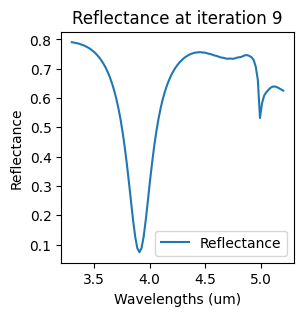

In [ ]:
reflectance = sim_data_for_checking[FLUX_MONITOR_FOR_CHECKING_NAME].flux

plt.figure(figsize=(3, 3))
plt.plot(wvls_for_checking, reflectance, label='Reflectance')
plt.xlabel('Wavelengths (um)')
plt.ylabel('Reflectance')
plt.legend()
plt.title(f'Reflectance at iteration {itr}')
plt.show()

In [ ]:
%%script echo skip

sim_for_checking = make_sim(params_history[-1])
sim_for_checking = sim_for_checking.updated_copy(monitors=[monitor_flux_for_checking])
sim_data_for_checking = web.run(simulation=sim_for_checking, task_name='last_iteration', path='data/last_iteration.hdf5', verbose=False)

skip


In [ ]:
%%script echo skip

reflectance = sim_data_for_checking[FLUX_MONITOR_FOR_CHECKING_NAME].flux

plt.figure(figsize=(3, 3))
# plt.scatter(wvls_for_checking, np.flip(reflectance))
plt.plot(wvls_for_checking, np.flip(reflectance), label='Reflectance')
plt.xlabel('Wavelength (um)')
plt.ylabel('Reflectance')
plt.legend()
plt.title(f'Reflectance at iteration 10')
plt.show()

skip
